In [1]:
import pandas as pd
from pathlib import Path
from hict.api.ContactMatrixFacet import ContactMatrixFacet
from hict.util.matrix_visualise import MatrixVisualise
import cooler
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from keras.models import load_model
import glob
import matplotlib.colors as clr
from HICT_Patterns.utils_scripts.models_methods import produce_model, predict_by_single_model
from HICT_Patterns.utils_scripts.produce_samples import make_samples
import pathlib
import shutil

In [2]:
local_path = 'D:/Study/HICT/HICT_Patterns/'
clr_map = clr.LinearSegmentedColormap.from_list('yarg', ['#e6e6e6','#000'], N=256)
clr_map_center = clr.LinearSegmentedColormap.from_list('yarg', ['#000','#fff'], N=256)
resolution = 10000

train_dir_centered = pathlib.Path(f'{local_path}datasets/images_center_10')
train_dir_uncentered = pathlib.Path(f'{local_path}datasets/images_10')
test_dir_centered = pathlib.Path(f'{local_path}datasets/temp_images_centered_{resolution//1000}')
test_dir_uncentered = pathlib.Path(f'{local_path}datasets/temp_images_uncentered_{resolution//1000}')

In [2]:
if os.path.exists(train_dir_centered):
    shutil.rmtree(train_dir_centered)
    os.mkdir(train_dir_centered)
else:
    os.mkdir(train_dir_centered)
os.mkdir(pathlib.Path(f'{train_dir_centered}/positive'))
os.mkdir(pathlib.Path(f'{train_dir_centered}/negative'))

if os.path.exists(train_dir_uncentered):
    shutil.rmtree(train_dir_uncentered)
    os.mkdir(train_dir_uncentered)
else:
    os.mkdir(train_dir_uncentered)
os.mkdir(pathlib.Path(f'{train_dir_uncentered}/positive'))
os.mkdir(pathlib.Path(f'{train_dir_uncentered}/negative'))

if os.path.exists(test_dir_uncentered):
    shutil.rmtree(test_dir_uncentered)
    os.mkdir(test_dir_uncentered)
else:
    os.mkdir(test_dir_uncentered)
os.mkdir(pathlib.Path(f'{test_dir_uncentered}/unknown'))

In [3]:
make_samples(train_dir_centered, clr_map_center, resolution, True)
make_samples(train_dir_uncentered, clr_map, resolution, False)

_short_
_short_2_
_long_
2_short_
2_short_2_
2_long_
_short_
_short_2_
_medium_
_long_
2_short_
2_short_2_
2_medium_
2_long_
_short_
_short_2_
_long_
2_short_
2_short_2_
2_long_
_short_
_short_2_
_medium_
_long_
2_short_
2_short_2_
2_medium_
2_long_


In [3]:
models_centered = produce_model(train_dir_centered, '/device:GPU:0', single_model=True)
models_uncentered = produce_model(train_dir_uncentered, '/device:GPU:0', single_model=True)

166/166 [==============================] - 1s 5ms/step - loss: 0.0075 - accuracy: 0.9974 - val_loss: 0.0172 - val_accuracy: 0.9947
Epoch 15/30
166/166 [==============================] - 1s 5ms/step - loss: 0.0102 - accuracy: 0.9959 - val_loss: 0.0072 - val_accuracy: 0.9977
Epoch 16/30
166/166 [==============================] - 1s 5ms/step - loss: 0.0110 - accuracy: 0.9966 - val_loss: 0.0054 - val_accuracy: 0.9985
Epoch 17/30
166/166 [==============================] - 1s 5ms/step - loss: 0.0086 - accuracy: 0.9976 - val_loss: 0.0445 - val_accuracy: 0.9872
Epoch 18/30
166/166 [==============================] - 1s 5ms/step - loss: 0.0076 - accuracy: 0.9972 - val_loss: 0.0055 - val_accuracy: 0.9970
Epoch 19/30
166/166 [==============================] - 1s 5ms/step - loss: 0.0109 - accuracy: 0.9972 - val_loss: 0.0056 - val_accuracy: 0.9985
Epoch 20/30
166/166 [==============================] - 1s 5ms/step - loss: 0.0064 - accuracy: 0.9983 - val_loss: 0.0096 - val_accuracy: 0.9970
Epoch 21/30

In [6]:
chr = 'scf5'
chunkFile = ContactMatrixFacet.get_file_descriptor(f'{local_path}data/arab_dongX_vs_mopti_2nd_try.hdf5')
ContactMatrixFacet.open_file(chunkFile)
ContactMatrixFacet.load_assembly_from_agp(chunkFile, Path(f'{local_path}data/mopti_female_assembly_2.agp'))
matrix = MatrixVisualise.get_matrix(chunkFile, 'scaffold_5', resolution, False)
'''
c = cooler.Cooler(f'{local_path}data/ARAB_vs_Coluzzii/ARAB_vs_Coluzzii_4DN.mcool::/resolutions/{resolution}')
matrix = c.matrix(balance=False)[0:]
'''
src_matrix = np.log10(matrix+1)
max_value = np.nanmax(src_matrix)
min_value = np.nanmin(src_matrix)

if os.path.exists(test_dir_centered):
    shutil.rmtree(test_dir_centered)
    os.mkdir(test_dir_centered)
else:
    os.mkdir(test_dir_centered)
os.mkdir(pathlib.Path(f'{test_dir_centered}/unknown'))

for i in range(10, src_matrix.shape[0]-10):
        point = (i, i)
        point_area = src_matrix[point[1]-10:point[1]+10, point[0]-10:point[0]+10]
        plt.imsave(f'{test_dir_centered}/unknown/all_{i*resolution}_{i*resolution}.png',  point_area, cmap=clr_map_center, vmax=max_value, vmin=min_value)


center_detections = predict_by_single_model(pathlib.Path(f'{test_dir_centered}/unknown'), model=models_centered)

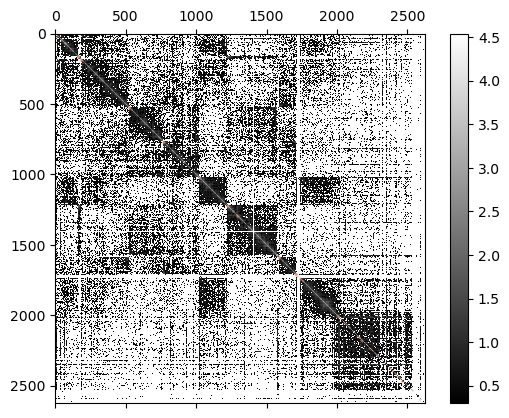

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.matshow(src_matrix, cmap=clr_map_center)
fig.colorbar(im)

plt.scatter([i[0]//resolution for i in center_detections],[i[1]//resolution for i in center_detections],s=0.1, c='#E9967A')

In [8]:
#remove heterochromatin area, coordinates acquired from plot
#also leave only one coordinate of point, because in pairs they are same
center_detections = sorted(center_detections)
center_detections_flat = [i[0] for i in center_detections if i[0] <= 2000*resolution]

In [9]:
if os.path.exists(test_dir_uncentered):
    shutil.rmtree(test_dir_uncentered)
    os.mkdir(test_dir_uncentered)
else:
    os.mkdir(test_dir_uncentered)
os.mkdir(pathlib.Path(f'{test_dir_uncentered}/unknown'))

for x in center_detections_flat:
    for y in center_detections_flat:
        if x <= y:
            continue
        point = (x//resolution, y//resolution)
        point_area = src_matrix[point[1]-10:point[1]+10, point[0]-10:point[0]+10]
        plt.imsave(f'{test_dir_uncentered}/unknown/all_{x}_{y}.png',  point_area, cmap=clr_map, vmax=max_value, vmin=min_value)


final_detections = predict_by_single_model(pathlib.Path(f'{test_dir_uncentered}/unknown'), models_uncentered)

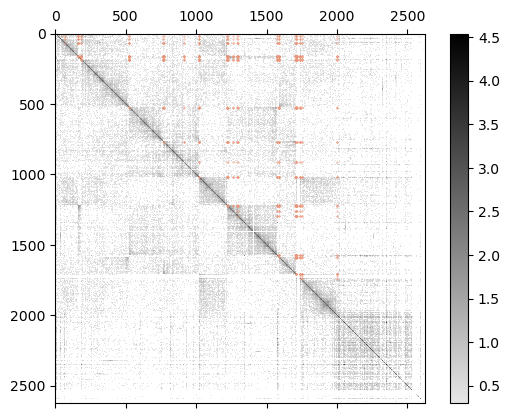

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.matshow(src_matrix, cmap=clr_map)
fig.colorbar(im)

plt.scatter([i[0]//resolution for i in final_detections],[i[1]//resolution for i in final_detections],s=0.1, c='#E9967A')
plt.savefig(f'{local_path}results_images/arab_dongX_vs_mopti_10k_conc.png', dpi=1000)

In [12]:
import keras
models_uncentered.compile()
models_uncentered.save(f"{local_path}/artifacts/final_model.keras")

In [6]:
from keras.utils import plot_model
type(models_centered)

In [13]:
from keras import Model
type(Model(inputs, outputs))